# Sentiment Timeseries

In [83]:
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [65]:
df = pd.read_csv(pathlib.Path("../data/news_select_companies_with_sent.csv"))
df

,Unnamed: 0,id,ticker,title,category,content,release_date,provider,url,article_id,dic_sentiment,dic_sentiment_dis
0,1305,222820,MSFT,Microsoft exposed 250M customer support records,news,Microsoft MSFT 0 1 discloses a database er...,2020-01-23,Seeking Alpha,https://invst.ly/pli4a,2065317,-0.0258,-1
1,1307,222822,MSFT,Microsoft CEO Fears U S China Mistrust Will H...,news,Bloomberg Sign up here to receive the Dav...,2020-01-21,Bloomberg,https://www.investing.com/news/stock-market-ne...,2063837,0.9620,1
2,3760,225275,MSFT,China Coronavirus Sells Off Asian Markets,opinion,Tuesday January 21 2020Market futures are in...,2020-01-20,Zacks Investment Research,https://www.investing.com/analysis/china-coron...,200500300,0.6584,1
3,3761,225276,MSFT,Tech Daily Facebook Apple Digital Taxes More,opinion,Facebook s NASDAQ FB role in elections and...,2020-01-21,Zacks Investment Research,https://www.investing.com/analysis/tech-daily-...,200500369,0.9970,1
4,3762,225277,MSFT,Chart Of The Day Can IBM s Results Help Avert...,opinion,International Business Machines NYSE IBM is ...,2020-01-21,Pinchas Cohen/Investing.com,https://www.investing.com/analysis/chart-of-th...,200500192,0.0979,1
...,...,...,...,...,...,...,...,...,...,...,...,...
60390,221241,442757,PFE,PSivida Small Cap BioTech Positioned For Long...,opinion,The following small cap company I find very in...,2012-04-18,Scott Matusow,https://www.investing.com/analysis/psivida:-sm...,120599,0.9997,1
60391,221246,442762,PFE,Cheap Is Not Always Good And Stocks As Sweaters,opinion,Cheap Is Not Always GoodThere are many investo...,2011-11-23,Helix Investment Management,https://www.investing.com/analysis/cheap-is-no...,106549,0.9922,1
60392,221247,442763,PFE,PROLOR Biotech A Top Takeover Candidate,opinion,Billionaire Phillip Frost is an esteemed entre...,2011-12-06,Takeover Analyst,https://www.investing.com/analysis/prolor-biot...,107900,0.9941,1
60393,221248,442764,PFE,2 Defensive Dividend Stocks Outperforming The SP,opinion,Looking to play defense in the market As the ...,2011-12-19,Double Dividend Stocks,https://www.investing.com/analysis/2-defensive...,109101,0.9951,1


# Data cleaning

In [66]:
sentiment_df = df[["ticker", "release_date", "dic_sentiment"]]

Make a dictionary with tickers as keys and DataFrames with date and sentiment as values.

In [67]:
ticker_dict = {}
for index, row in sentiment_df.iterrows():

    ticker = row["ticker"]
    date = row["release_date"]
    sentiment = row["dic_sentiment"]

    if ticker not in ticker_dict:
        ticker_dict[ticker] = pd.DataFrame(columns=["date", "sentiment"])

    new_row = pd.DataFrame({"date": [dt.strptime(str(date), "%Y-%m-%d").date()], "sentiment": [sentiment]})
    ticker_dict[ticker] = pd.concat([ticker_dict[ticker], new_row], ignore_index=True)


Take the monthly average of the sentiment.

In [68]:
def monthly_average(ticker_df):
    """
    Take the monthly average of the sentiment values.

    ticker_df: pd.DataFrame with dates (dt.datetime) and sentiments values.

    Returns a list of the new dates where the days are set to 1 and a list
    of the monthly average sentiment values.
    """
    ticker_df = ticker_df.sort_values(by="date")
    average_sentiments = []

    first_date = ticker_df["date"].iloc[0]
    current_month = first_date.month
    months = [dt(first_date.year, first_date.month, 1).date()]
    sentiments = [ticker_df["sentiment"].iloc[0]]

    for _, row in ticker_df.iterrows():
        sentiments.append(row["sentiment"])
        date = row["date"]

        if date.month != current_month:
            months.append(dt(date.year, date.month, 1).date())
            average_sentiments.append(np.mean(sentiments))
            current_month = date.month

    average_sentiments.append(np.mean(sentiments))

    return months, average_sentiments


Divide tickers in (random) groups of 5 for plotting, so plot doesn't get too crowded.

In [69]:
tickers = []
five_tickers = []

for i, ticker in enumerate(ticker_dict):
    i+=1
    five_tickers.append(ticker)
    if i % 5 == 0:
        tickers.append(five_tickers)
        five_tickers = []

print(tickers)


[['MSFT', 'TSLA', 'V', 'BAC', 'XOM'], ['KO', 'AAPL', 'PG', 'AMZN', 'HD'], ['LLY', 'WMT', 'UNH', 'MA', 'CVX'], ['JNJ', 'NVDA', 'MRK', 'JPM', 'PFE']]


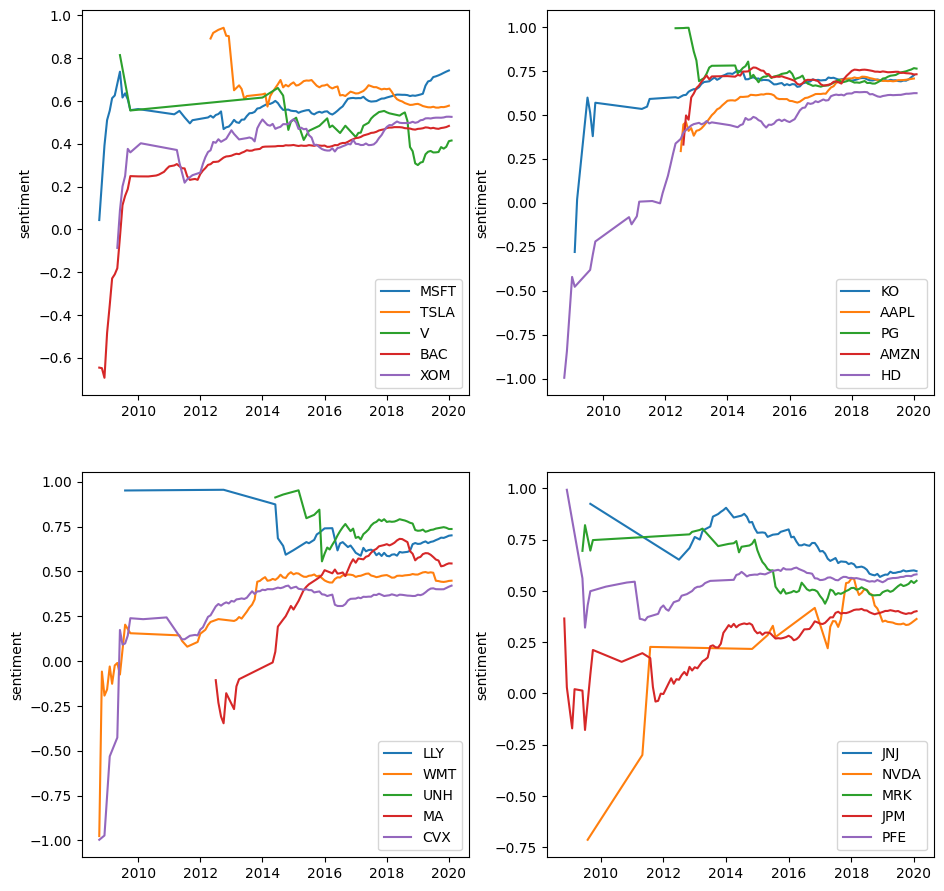

In [70]:
plt.figure(figsize= (11, 11))
for i, five_tickers in enumerate(tickers):
    i+=1
    plt.subplot(2, 2, i)

    for ticker in five_tickers:
        dates, sentiment = monthly_average(ticker_dict[ticker])
        plt.plot(dates, sentiment, label = ticker)
    plt.ylabel("sentiment")
    plt.legend()

plt.show()

In the above graphs we can observe that for most stocks there is not enough news article data before around 2014

In [71]:
def cut_data(dates, sentiments, start_date):
    """
    Remove all the data before the start date. If the start date
    is not in dates, find a next start_date that is in dates.
    """
    while start_date not in dates:
        start_date += relativedelta(months=+1)
    index = dates.index(start_date)
    return dates[index:], sentiments[index:]

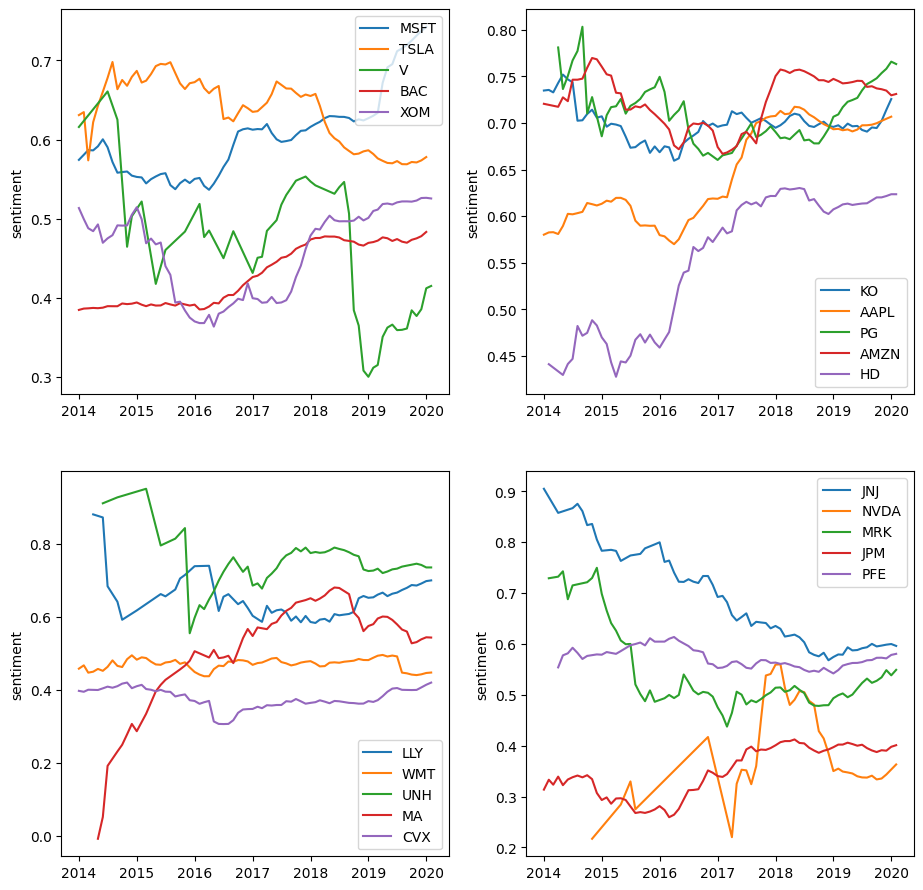

In [72]:
plt.figure(figsize= (11, 11))
for i, five_tickers in enumerate(tickers):
    i+=1
    plt.subplot(2, 2, i)

    for ticker in five_tickers:
        dates, sentiment = monthly_average(ticker_dict[ticker])

        # Remove all data from before 2014 and save in the ticker_dict
        cut_dates, cut_sentiment = cut_data(dates, sentiment, dt(2014, 1, 1).date())
        ticker_dict[ticker] = list(zip(cut_dates, cut_sentiment))

        plt.plot(cut_dates, cut_sentiment, label = ticker)

    plt.ylabel("sentiment")
    plt.legend()

plt.show()

The stocks in high to low order of sentiment data:

In [73]:
stocks = pd.read_csv(pathlib.Path("../data/used_companies.csv"))
stocks

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE,LLY,NVDA,MA,UNH,V


Throwing away the data of the 5 stocks with the least amount of sentiment data: V, UNH, MA, NVDA and LLY

In [74]:
del ticker_dict["V"]
del ticker_dict["UNH"]
del ticker_dict["MA"]
del ticker_dict["NVDA"]
del ticker_dict["LLY"]

# ADF Test

In [75]:
def stationary(data, variable) -> bool:
    """
    Test stationarity with augmented Dickey Fuller test. Testing the following hypothesis with
    the resulting p-value:

    H0: The data has a unit root and is stationary.

    Returns true if stationary else return false
    """

    print(f"Output results augmented Dickey Fuller test for variable: {variable}")
    results_augmented_dickey_fuller = adfuller(data)
    print('ADF Statistic: %f' % results_augmented_dickey_fuller[0])
    print('p-value: %f' % results_augmented_dickey_fuller[1])
    print('Critical Values:')
    for key, value in results_augmented_dickey_fuller[4].items():
        print('\t%s: %.3f' % (key, value))

    if results_augmented_dickey_fuller[1] <= 0.05:
        print("Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary")
        print('\n')
        return True
    else:
        print("Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary")
        print('\n')
        return False

In [76]:
stationary_tickers = []

for ticker in ticker_dict:
    sentiment = [value for _, value in ticker_dict[ticker]]
    if stationary(sentiment, ticker):
        stationary_tickers.append(ticker)

Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: 0.537018
p-value: 0.985956
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: TSLA
ADF Statistic: -0.905751
p-value: 0.786073
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -0.590344
p-value: 0.873149
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: XOM
ADF Statistic: -1.063957
p-value: 0.729229
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusio

In [77]:
stationary_tickers

['PG', 'WMT']

# Making time series stationary

To make the time series stationary we can compute the deratitive by taking the percentage differences.

In [78]:
for ticker in ticker_dict:
    dates, sentiments = list(zip(*ticker_dict[ticker]))

    # Calculate percentage differences
    sentiments_pct = pd.DataFrame(sentiments).astype(float).pct_change()
    sentiments_pct = sentiments_pct.iloc[:, 0].values.tolist()

    # Add percentage values to ticker dict
    # [1:] , because first value is nan for the percentage differences
    ticker_dict[ticker] = list(zip(dates, sentiments, sentiments_pct))[1:]


In [79]:
def plot_prc_chang(data, ticker):
    diffs = [diff for _, _, diff in data]
    dates = [date for date, _, _ in data]
    plt.plot(dates, diffs, label = ticker)
    plt.ylabel("Percentage difference sentiment")
    plt.legend()
    plt.show()

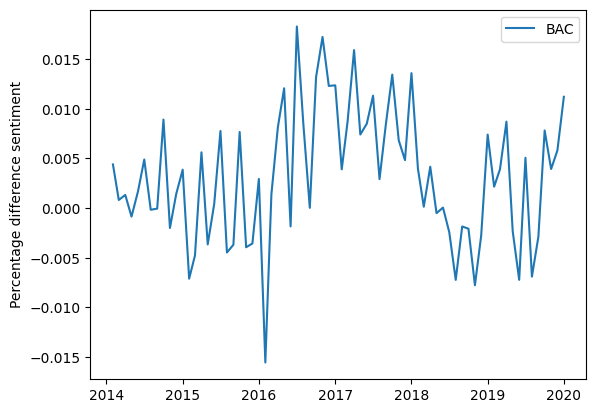

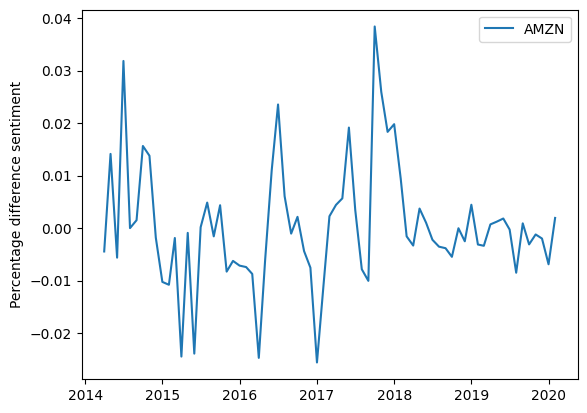

In [80]:
plot_prc_chang(ticker_dict["BAC"], "BAC")
plot_prc_chang(ticker_dict["AMZN"], "AMZN")

Now lets do the ADF test again:

In [81]:
not_stationary = []
for ticker in ticker_dict:
    diffs = [diff for _, _, diff in ticker_dict[ticker]]
    if not stationary(diffs, ticker):
        not_stationary.append(ticker)

Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -5.034206
p-value: 0.000019
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: TSLA
ADF Statistic: -9.205512
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -1.779485
p-value: 0.390693
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: XOM
ADF Statistic: -3.135127
p-value: 0.024061
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Conclusion

In [82]:
not_stationary

['BAC']

# Testing Skewness and Kurtosis

In [ ]:
def skewness(df):
    Skewed_variables = []
    Kurtosis_containing_variables = []

    for i in df.columns[:-1]:
        print(df[i].describe())
        print(f'Kurtosis: {df[i].kurtosis()}')
        print(f'Skewness: {df[i].skew()}')
        print('\n')
        if df[i].kurtosis() <= -10 or df[i].kurtosis() >= 10:
            Kurtosis_containing_variables.append(i)
        else:
            continue
        if df[i].skew() >= 3 or df[i].skew() <= -3:
            Skewed_variables.append(i)


    if len (Skewed_variables) == 0:
            print(f'All variables have skewness in acceptable ranges (-3 < skewness < 3)\n')
    if len (Kurtosis_containing_variables) == 0:
            print(f'All variables have kurtosis in acceptable ranges (-10 < kurtosis < 10)\n')
            print('\n')
    elif len (Kurtosis_containing_variables) != 0:
            print(f'Not all variables have kurtosis in acceptable ranges (-10 < kurtosis < 10). The variables which have kurtosis outside this range are: {Kurtosis_containing_variables}\n')
            print('\n')

In [85]:
df = pd.DataFrame()
for ticker in ticker_dict:
    diffs = [diff for _, _, diff in ticker_dict[ticker]]
    df[ticker] = diffs

df

['MSFT',
 'TSLA',
 'BAC',
 'XOM',
 'KO',
 'AAPL',
 'PG',
 'AMZN',
 'HD',
 'WMT',
 'CVX',
 'JNJ',
 'MRK',
 'JPM',
 'PFE']

# Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF)

ACF $\rightarrow$ taking in account all combinations for the Pearson correlation. Model example for correlation between now and two time units ago:

$$ \textrm{CORR}(s_{t-2}, s_t) $$

PACF $\rightarrow$ only taking in account the direct effect in the correlation and using linear regression with model:

$$ s_t = \beta_0 + \beta_1 s_{t-1} + \beta_2 s_{t-2} + \beta_3 s_{t-3} ... + \epsilon_t,$$

where $\beta_i$ gives us the direct effect of $s_{t-i}$ on $s_t$.


## ACF